In [1]:
import os
import json
import cv2
import torch
import random
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack as fft
from PIL import Image, ImageOps
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch import nn
from timm.scheduler.cosine_lr import CosineLRScheduler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torchvision.transforms as T
from timm.models import maxxvit

In [2]:
# Define the paths
train_npy_path = "/kaggle/input/signal-fast-radio-burst-detection/train/train"
train_csv_path = "/kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train"
test_npy_path = "/kaggle/input/signal-fast-radio-burst-detection/test/test"
output_dir = "/kaggle/working"
train_dir = os.path.join(output_dir, "train_dir")
#val_dir = os.path.join(output_dir, "val_dir")
test_dir = os.path.join(output_dir, "test_dir")

# Create output directories
os.makedirs(train_dir, exist_ok=True)
#os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Load CSV files
csv_files = [f for f in os.listdir(train_csv_path) if f.endswith('.csv')]
train_df = pd.DataFrame(columns=['index', 'image', 'label'])

# Process each .npy file and corresponding .csv file
for csv_file in csv_files:
    npy_file = csv_file.replace('_labels.csv', '.npy')
    npy_data = np.load(os.path.join(train_npy_path, npy_file))  # Shape: (262144, 256)
    csv_data = pd.read_csv(os.path.join(train_csv_path, csv_file))
    
    # Slice the npy_data into chunks of 256x256
    num_chunks = npy_data.shape[0] // 256  # 262144 / 256 = 1024 chunks
    for chunk_idx in range(num_chunks):
        # Extract a 256x256 chunk
        chunk = npy_data[chunk_idx * 256 : (chunk_idx + 1) * 256, :]  # Shape: (256, 256)
        
        # Save the chunk as an image
        image_path = os.path.join(output_dir, f"{npy_file.replace('+', '_').replace('-', '_').replace('.npy', '')}_{chunk_idx}.jpg")
        plt.imsave(image_path, chunk, cmap='gray')
        
        # Get the corresponding label from the CSV file
        label = csv_data.iloc[chunk_idx]['labels']
        
        # Append the new row to the DataFrame using pd.concat
        new_row = pd.DataFrame([{'index': f"{npy_file.replace('+', '_').replace('-', '_').replace('.npy', '')}_{chunk_idx}", 'image': image_path, 'label': label}])
        train_df = pd.concat([train_df, new_row], ignore_index=True)

train_df.to_csv('/kaggle/working/train_input_df.csv', index=False)
# Display the first few rows of the DataFrame
print(train_df.head(2))


                                       index  \
0  B1933_16_59475_68410_reduced_fc_0001023_0   
1  B1933_16_59475_68410_reduced_fc_0001023_1   

                                               image label  
0  /kaggle/working/B1933_16_59475_68410_reduced_f...   NaN  
1  /kaggle/working/B1933_16_59475_68410_reduced_f...   NaN  


In [3]:
train_df["label"].value_counts()

label
Unlabeled        11842
Narrow            8582
Uncertain         5721
Pulse             3847
Broad             3201
Narrow+Broad       138
Narrow+Pulse        60
Unknown+Pulse       37
Broad+Pulse          9
Name: count, dtype: int64

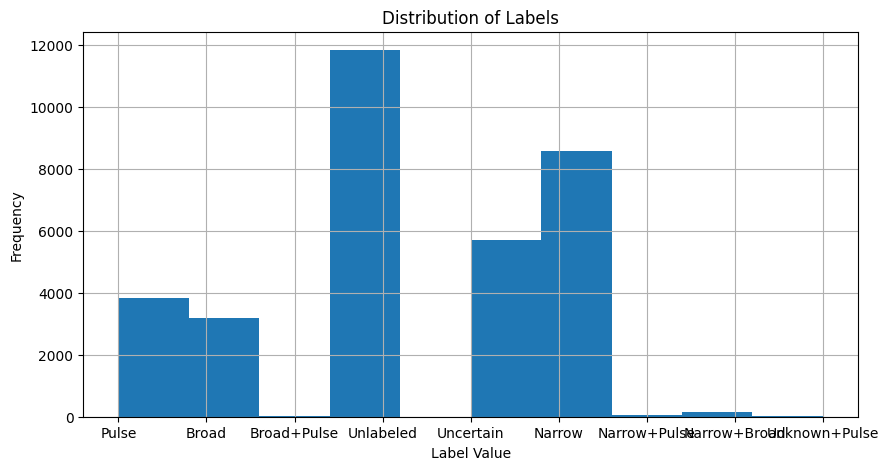

In [4]:
# Alternative, slightly more concise approach (but less flexible):
plt.figure(figsize=(10, 5)) # Create the figure *before* the hist call
train_df['label'].hist()
plt.title('Distribution of Labels')
plt.xlabel('Label Value')
plt.ylabel('Frequency')
plt.show()

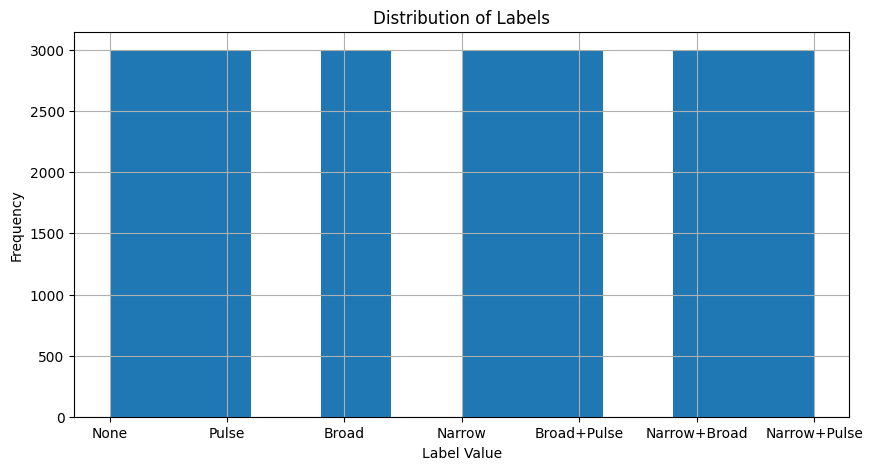

In [5]:
def drop_unknown_labels(df):
    labels_to_drop = ["Uncertain", "Unlabeled"]
    # Use isin() for efficient filtering
    mask = train_df['label'].isin(labels_to_drop)
    train_df.drop(train_df[mask].index, inplace=True)   
drop_unknown_labels(train_df)

# Replace train_df['label']with 'None'
train_df.fillna(0, inplace=True)
train_df.replace(0, "None", inplace=True)  # Correct!

train_df = pd.concat([
  train_df[train_df['label']=="None"].sample(n=3000,replace=True),
  train_df[train_df['label']=="Pulse"].sample(n=3000,replace=True),
  train_df[train_df['label']=="Broad"].sample(n=3000,replace=True),
  train_df[train_df['label']=="Narrow"].sample(n=3000,replace=True),
  train_df[train_df['label']=="Broad+Pulse"].sample(n=3000,replace=True),
  train_df[train_df['label']=="Narrow+Broad"].sample(n=3000,replace=True),
  train_df[train_df['label']=="Narrow+Pulse"].sample(n=3000,replace=True)
  ],axis=0)

plt.figure(figsize=(10, 5)) # Create the figure *before* the hist call
train_df['label'].hist()
plt.title('Distribution of Labels')
plt.xlabel('Label Value')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Create a mapping from string labels to integer indices
label_mapping = {
    "None": 0,
    "Pulse": 1,
    "Broad": 2,
    "Narrow": 3,
    "Broad+Pulse": 4,
    "Narrow+Broad": 5,
    "Narrow+Pulse": 6
}
train_df['label'] = train_df['label'].map(label_mapping)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [7]:
# Define the ImageDataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, transforms, has_labels=True):
        self.dataframe = dataframe
        self.transforms = transforms
        self.has_labels = has_labels  # Flag to indicate whether labels are present

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image']).convert("RGB")
        image = self.transforms(image)
        
        if self.has_labels:
            label = torch.tensor(row['label'], dtype=torch.long)  # Ensure label is of type torch.long
            return image, label
        else:
            return image  # Return only the image if labels are not present

# Define the transforms
img_size = (256, 256)
transforms = {
    "train": T.Compose([
        T.Resize(img_size, interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.5, 0.5, 0.5]), std=torch.tensor([0.234, 0.234, 0.234]))
    ]),
    "test": T.Compose([
        T.Resize(img_size, interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.5, 0.5, 0.5]), std=torch.tensor([0.234, 0.234, 0.234]))
    ]),
}

train_dataset = ImageDataset(train_df, transforms["train"], has_labels=True)
val_dataset = ImageDataset(val_df, transforms["test"], has_labels=True)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

In [8]:
# Define the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = maxxvit.maxxvitv2_nano_rw_256(pretrained=True, num_classes=len(label_mapping)).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# Training loop
n_epochs = 7
for epoch in range(n_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Val Loss: {val_loss/len(val_loader)}, Val Acc: {correct/total}')

# Save the model
#torch.save(model.state_dict(), "maxxvitv2_nano_rw_256.pth")

# Process the test set
test_files = [f for f in os.listdir(test_npy_path) if f.endswith('.npy')]
test_df = pd.DataFrame(columns=['id', 'image'])

for test_file in test_files:
    npy_data = np.load(os.path.join(test_npy_path, test_file))  # Shape: (262144, 256)
    num_chunks = npy_data.shape[0] // 256  # 262144 / 256 = 1024 chunks
    for chunk_idx in range(num_chunks):
        # Extract a 256x256 chunk
        chunk = npy_data[chunk_idx * 256 : (chunk_idx + 1) * 256, :]  # Shape: (256, 256)
        
        # Save the chunk as an image
        image_path = os.path.join(test_dir, f"{test_file.replace('.npy', '')}_{chunk_idx}.jpg")
        plt.imsave(image_path, chunk, cmap='gray')
        
        # Append the new row to the DataFrame using pd.concat
        new_row = pd.DataFrame([{'id': f"{test_file.replace('.npy', '')}_{chunk_idx}", 'image': image_path}])
        test_df = pd.concat([test_df, new_row], ignore_index=True)

# Create test dataset and dataloader
#test_dataset = ImageDataset(test_df, transforms["test"])
test_dataset = ImageDataset(test_df, transforms["test"], has_labels=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Make predictions on the test set
model.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:  # No labels returned
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        predictions.extend(predicted.cpu().numpy())

model.safetensors:   0%|          | 0.00/94.8M [00:00<?, ?B/s]

Epoch 1, Loss: 0.6524853706359863, Val Loss: 0.5817001406457487, Val Acc: 0.7171428571428572
Epoch 2, Loss: 0.10575112700462341, Val Loss: 0.24198430676027397, Val Acc: 0.9147619047619048
Epoch 3, Loss: 0.02579382061958313, Val Loss: 0.16303949544521423, Val Acc: 0.9471428571428572
Epoch 4, Loss: 1.3582929372787476, Val Loss: 0.13582620212904306, Val Acc: 0.9542857142857143
Epoch 5, Loss: 0.0011449067387729883, Val Loss: 0.12508464959439441, Val Acc: 0.9576190476190476
Epoch 6, Loss: 0.02520635351538658, Val Loss: 0.1573351805957969, Val Acc: 0.9395238095238095
Epoch 7, Loss: 0.0017049522139132023, Val Loss: 0.12810475687751327, Val Acc: 0.9419047619047619


In [9]:
# Create submission file
submission = pd.DataFrame(columns=['id', 'pulse', 'broad', 'narrow'])
for idx, row in test_df.iterrows():
    pred = predictions[idx]
    if pred == 0:  # None
        submission = pd.concat([submission, pd.DataFrame([{'id': row['id'], 'pulse': 0, 'broad': 0, 'narrow': 0}])], ignore_index=True)
    elif pred == 1:  # Pulse or Unknown+Pulse"
        submission = pd.concat([submission, pd.DataFrame([{'id': row['id'], 'pulse': 1, 'broad': 0, 'narrow': 0}])], ignore_index=True)
    elif pred == 2:  # Broad
        submission = pd.concat([submission, pd.DataFrame([{'id': row['id'], 'pulse': 0, 'broad': 1, 'narrow': 0}])], ignore_index=True)
    elif pred == 3:  # Narrow
        submission = pd.concat([submission, pd.DataFrame([{'id': row['id'], 'pulse': 0, 'broad': 0, 'narrow': 1}])], ignore_index=True)
    elif pred == 4:  # Broad+Pulse or Pulse+Broad
        submission = pd.concat([submission, pd.DataFrame([{'id': row['id'], 'pulse': 1, 'broad': 1, 'narrow': 0}])], ignore_index=True)
    elif pred == 5:  # Narrow+Broad orBroad+Narrow
        submission = pd.concat([submission, pd.DataFrame([{'id': row['id'], 'pulse': 0, 'broad': 1, 'narrow': 1}])], ignore_index=True)
    elif pred == 6:  # Narrow+Pulse or Pulse+Narrow
        submission = pd.concat([submission, pd.DataFrame([{'id': row['id'], 'pulse': 1, 'broad': 0, 'narrow': 1}])], ignore_index=True)
df0 = pd.read_csv('/kaggle/input/signal-fast-radio-burst-detection/sample_submission.csv')
df1 = df0['id']
submission = pd.merge(df1, submission, on='id', how='left')
# Save submission file
submission.to_csv(os.path.join(output_dir, "submission_maxxvitv2_nano_rw_256_7eps.csv"), index=False)
print("Copmplate to submission_maxxvitv2_nano_rw_256_7eps.csv")

Copmplate to submission_maxxvitv2_nano_rw_256_7eps.csv
